# Metrics and Errors

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import re
import ast
import matplotlib.pyplot as plt
from metrics_utils import *
from pathlib import Path

import matplotlib.ticker as mtick
plt.style.reload_library()
import matplotlib.patches as mpatches
from src import plot_utils

sns.set_theme()

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

## 1. Generate synthetic data

Produces a set of confussion matrices, simulating two types of errors: experimental and model errors. 

- Model errors are reproduced by random horizontal swaps (eg. a sample labeled as a positive prediction is changed to a negative prediction). 
- Experimental error are reproduced by vertical swaps (eg. an actual positive sample is considered as a true negative).

Given a positive proportion (P), a percentile of true positive (TP) and a percentile of true negative (TN), a confussion matrix is defined which will be then used as a seed to create more random matrices.  

In [4]:
def create_cm_seed(positive_prop, percentile_tp, percentile_tn=0.8):
    """Create a confussion matrix with normalized values. 

    Args:
        positive_prop (float): proportion of positive samples
        percentile_tp (float): proportion of true positive over positives samples
        percentile_tn (float, optional): proportion of true negatives over negatives samples. Defaults to 0.8.

    Returns:
        [type]: [description]
    """
    tp = percentile_tp * positive_prop 
    fn = positive_prop-tp
    tn = (1-positive_prop) * percentile_tn
    fp = 1-tp-fn-tn
    return [tn, fp, fn, tp, positive_prop, percentile_tp]

From each confussion matrix seed, generate `m_matrices` which will have an error proportion `error_prop`. 

Simulate errors by random horizontal and/or vertical swaps.

In [5]:
def set_experiment(confusion_matrix_args, error_type="exp", error_prop=0.15, seed=1, alpha=0.10):
    """ 
    Args:
        confusion_matrix_args ([dicctionary]): Parameters that defines a seed confussion matrix
        error_type ([string]): Type of error to be simulated. "exp" refers to experimental error, "model" to model errors
        and "both" to both error types.
        seed (int, optional): Random seed to simulate errors. Defaults to 1.
        alpha (float, optional): [description]. When error_type is "both", alpha is the fraction of experimental errors,
        the remaining proportion 1-alpha corresponds to model error.

    Returns:
        [type]: [description]
    """
    np.random.seed(seed=seed)
    imbalances = confusion_matrix_args["positive"] 
    percentiles_tp = confusion_matrix_args["tn_percentil"]
    n_matrix_size = confusion_matrix_args["n_size"]
    m_matrices = confusion_matrix_args["m_matrices"]
    
    # Generate samples from each confussion matrix seed
    seed_confusion_matrix = [create_cm_seed(imb, ptl) for imb in imbalances for ptl in percentiles_tp]
    df = pd.DataFrame(seed_confusion_matrix, columns=["tn", "fp", "fn", "tp", "imbalance", "percentil_tp"])
    df.iloc[:, 0:4] = df.iloc[:, 0:4] * n_matrix_size
    df[["tn", "fp", "fn", "tp"]]  = df.iloc[:, 0:4].round(0).astype(int)
    idx_repeated = df.index.repeat(m_matrices)
    df = df.loc[idx_repeated]
    df = df.reset_index(drop=True)
    
    # Simulate errors by random pick & puts
    errors = n_matrix_size * error_prop
    for row in df.itertuples():
        simulate_error_cm(df, row, error_type, errors, alpha)

    confusion_matrix_args["seed"] = seed
    confusion_matrix_args["error_type"] = error_type
    confusion_matrix_args["error_prop"] = error_prop
    if error_type == "exp-model":
        # as percentages
        confusion_matrix_args["error_exp"] = int(error_prop*alpha*100)
        confusion_matrix_args["error_model"] = int(error_prop*100)-confusion_matrix_args["error_exp"]
    data_info = {"data": df,
                 "metadata": confusion_matrix_args}
    
    return data_info


def simulate_single_error(df, type_error_to_simulate, row):
    i = row.Index
    done_simulation = False
    while(not done_simulation):
        flip_cm_class = np.random.randint(0,2)
        class_from = np.random.randint(0,2)
        class_to = not class_from
        if type_error_to_simulate == "model":
            index_cm_from = flip_cm_class*2 + class_from
            index_cm_to = flip_cm_class*2 + class_to
        elif type_error_to_simulate == "exp":
            index_cm_from = flip_cm_class + class_from * 2
            index_cm_to = flip_cm_class + class_to * 2
        if df.iloc[i,index_cm_from] > 0:
            df.iloc[i,index_cm_from] -= 1
            df.iloc[i,index_cm_to] += 1
            done_simulation = True
              
                
def simulate_error_cm(df, row, error_type, errors, alpha):
    if error_type == "exp-model":
        model_error = round(errors * alpha)
        exp_error = round(errors-model_error)
        reamining_errors = {"exp": exp_error,
                            "model": model_error}
        while sum(reamining_errors.values()) > 0:
            proposed_type_error = np.random.choice(["exp", "model"])
            type_error_to_simulate = proposed_type_error if reamining_errors[proposed_type_error] > 0 else "exp"
            simulate_single_error(df, type_error_to_simulate, row)
            reamining_errors[type_error_to_simulate]-=1
    else:
        permutation_remaining = errors
        while permutation_remaining > 0:
            simulate_single_error(df, error_type, row)
            permutation_remaining -= 1

In [2]:
example = pd.read_csv("exp_model/{'positive': [0.1, 0.4], 'tn_percentil': [0.25, 0.5, 0.75], 'n_size': 75, 'm_matrices': 250, 'seed': 0, 'error_type': 'exp', 'error_prop': 0.15}.csv")

NameError: name 'pd' is not defined

In [6]:
positive_proportions = [0.10, 0.4]
tp_percentiles = [0]

m_matrices = 3
n_size = 300

confusion_matrix_args = {"positive":positive_proportions,
                        "tn_percentil":tp_percentiles}

confusion_matrix_args["n_size"] = n_size
confusion_matrix_args["m_matrices"] = m_matrices


In [ ]:
data_info = set_experiment(confusion_matrix_args, error_type = "exp-model", error_prop = 0.15, seed=1, alpha=0.3)


In [3]:
data_info["data"]['test'] =(data_info["data"]['precision_weighted']+data_info["data"]['recall_weighted'])/2

NameError: name 'data_info' is not defined

In [4]:
(0.80+0.72)/2

0.76

In [7]:
def add_metric_to(df, metric, average):
    """ Compute and add metric score as a new column. df must contain confussion matrices.
    Args:
        df ([pandas dataframe]): confussion matrices.
        metric ([str]): possible options: "recall", "F1", "precision", "matthew".
        average ([str]): way to average score across classes. Possible options: "macro", "micro", "weighted".
    Returns:
        [pandas dataframe]: df with metric score as column.
    """
    if not metric.startswith("matthew"):
        name_metric = metric + "_" + average
    else: name_metric = metric
    df[name_metric] = df.apply(lambda row: from_row_get_metric(row, metric=metric, m_average=average), axis=1)

In [6]:
for metric in ['recall', 'F1']:
    add_metric_to(data_info["data"], metric, 'weighted')

NameError: name 'data_info' is not defined

## Experiments


### 1. Search complement metric

Recall is the deafault metric by problem definition. Matthew is the metric to benchmark with.
Metrics complements is measured by how well they both together allow you to diferentiate two noisy matrices from different seed matrices. 

#### Model error



#### Experiment error

### 2. Error variability by matrix size (n)


### 3. Metric's Distribution Overlap

### Extrapolación 

Cada matrix de confusión representa la performance del modelo para un conjunto de experimentos llevados 
en el laboratorio para una amina en particular.

Nosotres estamos confiando los resultados del trabajo en un subconjunto de datos para cada amina (~200 datos) 

Queremos saber si podemos extrapolar:
    - en qué condiciones se puede entrenar para que extrapole
    - si para algunas funciona mejor, por qué 

Supongamos un espacio de entrenamiento finito discretizable acotado:
    - por conocimiento del problema (ej. concentración ácido < 5 M, temperatura < 130°)
    - por metodología/intrumentación experimental

Luego si tuviésemos el total de los datos posibles y corríamos el modelo, podríamos armar una matriz 
que indique fielmente cómo es la performance del modelo con respecto a esa amina. 
Sea esta la **matriz semilla**. 

Luego, al trabajar con un subconjunto de ese espacio total, la matriz experimental será un tanto "similar" 
a la matriz semilla (lo cual modelaremos mediante np.random).

De modo que tendremos muchas posibles mediciones de performance del modelo. 
Alguna de ellas se corresponde con nuestros datos...solo una. 
¿Qué tanto podemos confiar en ella?

OBS: Con muchos posible subconjuntos de datos del real, podemos tener la misma matriz. 
Cada matriz es una clase de equivalencia de los subconjuntos (x, y_true, y_pred).


Supongamos que tenemos muchos datos hechos en el laboratorio para cada amina.
En el caso ideal una cantidad significativa de experimentos nos habla de qué tan bien predice el modelo 
sobre datos de una amina en particular.
Nosotres solo tendremos acceso a una cantidad n_amine_sample, es decir, nos quedamos con 
una perspectiva sesgada de cómo anda el modelo.
    - Por ahí justo para esa cantidad de datos anda bien
    - Por ahí justo para esa cantidad y datos experimentales anda mal
    - Etc

Objetivo Principla: 
    Queremos identificar para qué aminas el modelo predice adecuadamente.

Para ello debemos:
    - Saber qué tanto se parece esa __sample__ al comportamiento esperado.
Queremos no equivocarnos al decir que el modelo no aprendió bien para una amina. Es decir, 
no queremos equivocarnos entre tipos dado que luego

Para ello: 
    1. Definimos una performance real del modelo para cada amina tipo (aka matrices semilla)
    2. Generamos matrices 
Diremos que el comportamiento esperado es  



Nos gustaría poder identificar facilmente con qué aminas está funcionando y vale la pena seguir vs con cuales renunciar. Análisis visual de dos métricas para descartar cómo está performando el modelo con respecto a la realidad de la amina

In [7]:
%matplotlib inline

In [8]:
metrics = ['precision_macro',
        'precision_micro',
        'recall_macro',
        'recall_micro',
        'f1_weighted',
        'recall_weighted',
        'precision_weighted',
        'f1_macro',
        'matthew']

def map_names_for_plot(cols_metrics=metrics):
    map_names = { metric: metric.replace("precision", "Precision")
                .replace("_", " ")
                .replace("f1", "F1")
                .replace("recall", "Recall")   
                .replace("matthew", "Matthew")   
                for metric in cols_metrics}
    map_names["percentil_tp"] = 'Percentil'
    map_names["imbalance"] = r'$\delta$'
    map_names["exp"] = "Experimental"
    map_names["model"] = "Modelo"
    map_names["exp-model"] = "Exp-modelo"
    map_names["n_size"] = "m"
    return map_names

In [9]:
positive_proportions = [0.10, 0.4]
tp_percentiles = [0.25,0.5,0.75]


m_matrices_ls = [250]
n_size_ls = [100, 600, 1200]

alpha_ls = [0]

def run_experiment(error_type, m_matrices_ls, n_size_ls, 
                   positive_proportions=[0.10, 0.4],
                   tp_percentiles=[0.25,0.5,0.75],
                   alphas = [0],
                   n_run=1, path=""):
    
    confusion_matrix_args = {"positive":positive_proportions,
                             "tn_percentil":tp_percentiles}
    
    data_folder = Path(path)
    data_folder.mkdir(parents=True, exist_ok=True)
    files = []
    
    metrics_to_compute = {
                        "precision": {"micro", "macro", "weighted"},
                        "recall": {"micro", "macro", "weighted"},
                        "f1":{"macro", "weighted"},
                        "matthew": {"score"}
                        }
    
    for seed in range(n_run):
        # using default 0.8 for true negative proportion
        for n_size in n_size_ls:
            for m_matrices in m_matrices_ls:
                for alpha in alphas:
                    confusion_matrix_args["n_size"] = n_size
                    confusion_matrix_args["m_matrices"] = m_matrices
                    data_info = set_experiment(confusion_matrix_args, error_type = error_type,
                                               error_prop = 0.15, seed=seed, alpha=alpha)

                    for metric in metrics_to_compute.keys():
                        for average in metrics_to_compute[metric]:
                            add_metric_to(data_info["data"], metric, average)
                    
                    #if 'tn_percentil' in data_info["metadata"]: del data_info["metadata"]['tn_percentil']
                    file_name = Path(data_folder / (str(data_info["metadata"]) + ".csv") )
                    data_info["data"].to_csv(file_name, index=False)
                    files.append(file_name)
    return files

In [12]:
files_test = run_experiment(error_type="model", m_matrices_ls=[10], n_size_ls=[10],
               n_run=1, path="test2")

In [541]:
files_exp_test = run_experiment(error_type="exp", m_matrices_ls=m_matrices_ls, n_size_ls=n_size_ls,
               n_run=1, path="exp_1_agosto_sin_alphas")

In [542]:
files_exp_test = run_experiment(error_type="model", m_matrices_ls=m_matrices_ls, n_size_ls=n_size_ls,
               n_run=1, path="model_1_agosto_sin_alphas")

In [571]:
files_exp_test = run_experiment(error_type="exp-model", m_matrices_ls=m_matrices_ls, n_size_ls=n_size_ls,
               n_run=1, alphas = alpha_ls, path="results_full_model")

In [ ]:
files_test = run_experiment(error_type="model", m_matrices_ls=[10], n_size_ls=[10],
               n_run=1, path="test2")

In [10]:
def plot_files(path, plot_fun, plot_args={}):
    path_src = Path(path)
    if path_src.is_dir():
        plot_folder = Path(path + "_plots")
        plot_folder.mkdir(parents=True, exist_ok=True)
        for src_filename in path_src.iterdir():
            plot_fun(src_filename, plot_folder, plot_args) 
    #elif path_src.is_file(): 
    #   plot_fun(path_src, plot_args, Path(plot_folder/src_filename)) 
    
def plot_each_file(path_folder, fun_plot, plot_folder="", plot_args={}):
    path_src = Path(path_folder)
    path_dts = Path(path_folder+"_"+"plot"+"_"+ plot_folder)
    path_dts.mkdir(parents=True, exist_ok=True)
    if path_src.is_dir():
        for src_filename in path_src.iterdir():
            fun_plot(src_filename, path_dts, plot_args)
            

def plot_merged_files_from(path, plot_fun, plot_args={}):
    path_src = Path(path)
    df_ls = []
    if path_src.is_dir():
        for src_filename in path_src.iterdir():
            df = pd.read_csv(src_filename)
            filename = src_filename.stem
            plot_variables = map_from_filename(filename)
            df["n_size"] = plot_variables["n_size"]
            if plot_variables["error_type"] == "exp-model":
                df["error_exp"] = plot_variables["error_exp"] 
                df["error_model"] = plot_variables["error_model"] 
            df_ls.append(df)
            plot_args["plot_variables"] = plot_variables
    df = pd.concat(df_ls, axis=0, ignore_index=True)
    plot_folder = Path(plot_args.get("output_path", path + "_plots"))
    plot_folder.mkdir(parents=True, exist_ok=True)

    if plot_variables["error_type"] == "exp-model":
        values_slices = df["error_exp"].unique()
        for value_slice in values_slices:
            filtered_data = df.loc[df["error_exp"] == value_slice]
            plot_variables["error_exp"] = value_slice
            plot_variables["error_model"] = filtered_data["error_model"].unique()[0]
            plot_args["plot_variables"] = plot_variables
            plot_comparision(filtered_data, plot_fun, plot_folder, plot_args)
    else:
        plot_comparision(df, plot_fun, plot_folder, plot_args)
    
 
        
def plot_comparision(df, plot_fun, plot_folder, plot_args):
    percentil_tp = {
        0.25: 'Pobre',
        0.5: 'Regular',
        0.75: 'Buena'
    }
    imbalance_category = {
        0.1: 'Alto',
        0.4: 'Bajo'
    }

    df = df.replace({'percentil_tp': percentil_tp})
    df = df.replace({'imbalance': imbalance_category})
    
    metrics = plot_args["metrics"]
    import itertools
    for metric_x, metric_y in itertools.combinations(metrics, 2):
        plot_args["x_metric"] = metric_x
        plot_args["y_metric"] = metric_y
        plot_fun(df, plot_folder, plot_args)   

In [59]:
def map_from_filename(file_name):
    str_map_match = re.search(r'\{.*\}', file_name).group(0)
    return ast.literal_eval(str_map_match)

def make_title_from_vars(map_cols, plot_variables):
    plot_title = "Tipo de Error: {} | N muestras: {} | M matrices: {} | semilla: {}\n"
    vars_in_plot_title = [map_cols[plot_variables["error_type"]],
                                    plot_variables["n_size"], plot_variables["m_matrices"], plot_variables["seed"]]
    if plot_variables["error_type"] == "exp-model":
        plot_title += " Error Exp: {} %".format(plot_variables["error_exp"])
        plot_title += " | Error Modelo: {} %\n".format(plot_variables["error_model"])
        extract = "| N muestras: {}".format(plot_variables["n_size"])
        plot_title.replace(extract, "")
    plot_title = plot_title.format(*vars_in_plot_title)
    return plot_title   
    
            
def plot_compare_metrics_distribution(file_path, plot_folder, plot_args={}):
    map_cols = map_names_for_plot()
    all_metrics = ["precision_macro", "precision_micro", "f1_weighted", "f1_macro", "matthew"]
    metrics = plot_args.get("metrics_to_plot", all_metrics)
    df = pd.read_csv(file_path)
    df["imbalance"] = df["imbalance"]*100
    df["imbalance"] = df["imbalance"].astype(int)
    df = df.rename(columns=map_cols)
    filename = file_path.stem
    plot_variables = map_from_filename(filename)
    for metric in metrics:
        ax = sns.displot(df, x=map_cols[metric], hue=map_cols["percentil_tp"], kind="kde",
                         col=map_cols["imbalance"], fill=True, common_norm=False, palette="deep",
                         alpha=.5, linewidth=3, legend=False, hue_order=[0.75, 0.5, 0.25])
        ax.set(ylabel='Distribución')
        ax.add_legend(labels=["$Q_{25}$", "$Q_{50}$", "$Q_{75}$"],
                      title="Percentil TP",
                      label_order=[0.25, 0.5, 0.75])
        ax.set_titles('Desbalance = {col_name}%')
        
        ax.fig.subplots_adjust(top=0.80)
        plot_title = make_title_from_vars(map_cols, plot_variables)
        ax.fig.suptitle(plot_title, fontsize=14)
        plot_path = plot_folder / (filename + "_"+ metric + ".png")
        plt.savefig(plot_path, facecolor='w', transparent=False, dpi=150)

def plot_compare_metrics_distribution(file_path, plot_folder, plot_args={}):
    map_cols = map_names_for_plot()
    all_metrics = ["precision_macro", "precision_micro", "f1_weighted", "f1_macro", "matthew"]
    metrics = plot_args.get("metrics_to_plot", all_metrics)
    df = pd.read_csv(file_path)
    df["imbalance"] = df["imbalance"]*100
    df["imbalance"] = df["imbalance"].astype(int)
    df = df.rename(columns=map_cols)
    filename = file_path.stem
    plot_variables = map_from_filename(filename)
    for metric in metrics:
        ax = sns.displot(df, x=map_cols[metric], hue=map_cols["percentil_tp"], kind="kde",
                         col=map_cols["imbalance"], fill=True, common_norm=False, palette="deep",
                         alpha=.5, linewidth=3, legend=False, hue_order=[0.75, 0.5, 0.25])
        ax.set(ylabel='Distribución')
        ax.add_legend(labels=["$Q_{25}$", "$Q_{50}$", "$Q_{75}$"],
                      title="Percentil TP",
                      label_order=[0.25, 0.5, 0.75])
        ax.set_titles('Desbalance = {col_name}%')
        
        ax.fig.subplots_adjust(top=0.80)
        plot_title = make_title_from_vars(map_cols, plot_variables)
        ax.fig.suptitle(plot_title, fontsize=14)
        plot_path = plot_folder / (filename + "_"+ metric + ".png")
        plt.savefig(plot_path, facecolor='w', transparent=False, dpi=150)


def plot_scatter(df, plot_folder, plot_args={}):

    sns.set_context("notebook")
    map_cols = map_names_for_plot()

    #filename = file_path.stem
    #plot_variables = map_from_filename(filename)
    #imbalance = plot_args["imbalance"]
    #df = df[df["imbalance"] == imbalance]
    x_metric = plot_args["x_metric"]
    y_metric = plot_args["y_metric"]
    hue_col = "imbalance"#"percentil_tp"
    
    df=df[df['n_size']==600]
    df = df.rename(columns=map_cols)
    #g = sns.FacetGrid(data=df, col=map_cols[hue_col])
    
    # Opción A: scatter
    with plt.style.context(['science', 'bright']):
        sns.set(font_scale = 1.7) 
        sns.set_context('poster')
        bright = plot_utils.tol_cset("bright")
        g = sns.relplot(data=df, x=map_cols[x_metric], y=map_cols[y_metric],
                        hue=map_cols["percentil_tp"], col=map_cols["imbalance"],
                        #row=map_cols["n_size"], 
                        palette=[bright.red, bright.blue, bright.green])
        
        
        g._legend.set_title("Performance")
        for ax in g.axes.flatten():
            #ax.set_yticklabels(rotation=90)
            ax.tick_params(labelbottom=True, which="both", left=False, bottom=False, top=False, right=False)
        
        for (col_key), ax in g.axes_dict.items():
            ax.set_title(f"Desbalance = {col_key}")
    ## Opción Hex
    # g = sns.FacetGrid(data=df, col=map_cols[hue_col], row=map_cols["n_size"], size=4)
    # def hexbin(x, y, color, **kwargs):
    #     cmap = sns.light_palette(color, as_cmap=True)
    #     plt.hexbin(x, y, gridsize=12, cmap=cmap, **kwargs)
    # x_min = df[map_cols[x_metric]].min()
    # y_min = df[map_cols[y_metric]].min()
    # x_max = df[map_cols[x_metric]].max()
    # y_max = df[map_cols[y_metric]].max()
    # g.map(hexbin, map_cols[x_metric], map_cols[y_metric], extent=[x_min, x_max, y_min, y_max], marginals=True)

        plot_variables = plot_args["plot_variables"]
        plot_title = make_title_from_vars(map_cols, plot_variables)
    #g.fig.suptitle(plot_title)
    #g.fig.subplots_adjust(top=0.93)
    
        plot_folder = Path(plot_folder)
        plot_folder.mkdir(parents=True, exist_ok=True)

        plot_path = plot_folder / (plot_title.replace("\n", " | ") + "_" + x_metric + ".png")
        plt.savefig(plot_path, facecolor='w', transparent=False, dpi=150)


def plot_joint(df, plot_folder, plot_args={}):
    sns.set_context("poster")
    map_cols = map_names_for_plot()
    #imbalance = plot_args["imbalance"]
    #df = df[df["imbalance"] == imbalance]
    x_metric = plot_args["x_metric"]
    hue_col = "percentil_tp"
    
    df=df[df['n_size']==600]
    df=df[df['imbalance']=='Alto']
    #g = sns.FacetGrid(data=df, col=map_cols[hue_col])
    x_metric = plot_args["x_metric"]
    y_metric = plot_args["y_metric"]
    # Opción A: scatter
    df = df.rename(columns=map_cols)
    
    with plt.style.context(['science', 'bright']):
        bright = plot_utils.tol_cset("bright")
    ## Opción scatter
    #g = sns.relplot(data=df, x=map_cols[x_metric], y=map_cols[y_metric],
    #                hue=map_cols["percentil_tp"], col=map_cols["imbalance"])

    ## Opción Hex
        g = sns.JointGrid(data=df, x=map_cols[x_metric], y=map_cols[y_metric], hue=map_cols[hue_col],
                          palette=[bright.red, bright.blue, bright.green],
                          height=7
                         )
        #g.plot(sns.scatterplot, sns.boxplo)
        g.plot_joint(sns.kdeplot, alpha=.3, fill=True, levels=4)
        #g.plot_joint(sns.scatterplot, alpha=.2)
        #g.plot_joint(sns.histplot, discrete=(False, False), cmap="light:#03012d", pmax=.8,
        #             bins=30,
        #             cbar=False)
    
        g.plot_marginals(sns.histplot, kde=True)
        #legend_properties = {'size': 8, }
        #legend_main = g.ax_joint.legend(prop=legend_properties, fontsize=6)
        
        g.ax_marg_y.tick_params(which="both", left=False, bottom=False, top=False, right=False)
        g.ax_marg_x.tick_params(which="both", left=False, bottom=False, top=False, right=False)
        g.ax_joint.tick_params(which="both", left=False, bottom=False, top=False, right=False)
        sns.move_legend(g.ax_joint, "lower right", title='Performance',
                        frameon=True, fontsize=13, title_fontsize='small')
    #g = sns.jointplot(data=df, x=map_cols[x_metric], y=map_cols[y_metric], hue=map_cols[hue_col],
    #                  xlim = (-0.4,1.15), ylim = (0,1.1))
    #g.plot_joint(sns.scatterplot)
    #g.plot_marginals(sns.kdeplot, zorder=3, levels=1)
    #g.plot_marginals(sns.rugplot, height=.05, clip_on=True)
        plot_variables = plot_args["plot_variables"]
        plot_title = make_title_from_vars(map_cols, plot_variables)
    #g.fig.suptitle(plot_title)
    #g.fig.subplots_adjust(top=0.93)
        #plt.legend(loc='lower right', bbox_to_anchor=(1,0.5))
        
        plot_folder = Path(plot_folder)
        plot_folder.mkdir(parents=True, exist_ok=True)
        

        plot_path = plot_folder / (x_metric + "_" + y_metric + ".png")
        plt.savefig(plot_path, facecolor='w', transparent=False, dpi=150)
        
  # g.savefig("img/recall_vs_{}_imbalance_{}.jpg".format(x_metric, imbalance), transparent=True,  facecolor='w')
    #plt.savefig("img_final_cross/recall_vs_{}_imbalance_{}_seed_{}_n_{}_cm_{}.png".format(x_metric, imbalance, seed, n, cm_sample),facecolor='w', transparent=False, dpi=150)

def plot_compare_metrics(path_src, output_path, plot_fun=plot_scatter):
    plot_merged_files_from(path_src, plot_fun, plot_args={
                                                            "metrics": ["recall_macro","precision_macro", "f1_macro", "matthew"],
                                                            "output_path": output_path
                                                            })

    
def plot_joint_with_evaluation(df, plot_folder, plot_args={}):
    sns.set_context("poster")
    map_cols = map_names_for_plot()
    x_metric = plot_args["x_metric"]
    hue_col = "percentil_tp"
    
    df=df[df['n_size']==600]
    df=df[df['imbalance']=='Alto']
    x_metric = plot_args["x_metric"]
    y_metric = plot_args["y_metric"]
    df = df.rename(columns=map_cols)
    
    df_evaluation = pd.read_csv(plot_args['evaluation_dot_path'])
    map_cols = map_names_for_plot(df_evaluation.columns)
    
    df_evaluation = df_evaluation.rename(columns=map_cols)
    
    df_evaluation = df_evaluation.rename(columns={metric: metric+' macro' for metric in ['Recall', 'F1', 'Precision', 'Matthew']})
    
    with plt.style.context(['science', 'bright']):
        bright = plot_utils.tol_cset("bright")
        print(df.columns, df_evaluation.columns)
        print(x_metric, map_cols)
        
        g = sns.JointGrid(data=df, x=map_cols[x_metric], y=map_cols[y_metric], hue=map_cols[hue_col],
                          palette=[bright.red, bright.blue, bright.green],
                          height=7
                         )
        
        #g.plot(sns.scatterplot, sns.boxplo)
        g.plot_joint(sns.kdeplot, alpha=.3, fill=True, levels=4)
        #g = g.plot_joint(plt.scatter, color=".5", edgecolor="white")
        g.plot_marginals(sns.histplot, kde=True)
        sns.scatterplot(ax=g.ax_joint, data=df_evaluation, x=map_cols[x_metric], y=map_cols[y_metric])
        #g.ax_marg_y.tick_params(which="both", left=False, bottom=False, top=False, right=False)
        #g.ax_marg_x.tick_params(which="both", left=False, bottom=False, top=False, right=False)
        #g.ax_joint.tick_params(which="both", left=False, bottom=False, top=False, right=False)
        ##sns.move_legend(g.ax_joint, "lower right", title='Performance',
        #                frameon=True, fontsize=13, title_fontsize='small')
        #plot_variables = plot_args["plot_variables"]
        #plot_title = make_title_from_vars(map_cols, plot_variables)
        
        #plot_folder = Path(plot_folder)
        #plot_folder.mkdir(parents=True, exist_ok=True)
        

        plot_path = plot_folder / (x_metric + "_" + y_metric + ".png")
        #plt.savefig(plot_path, facecolor='w', transparent=False, dpi=150)
        
    

## for evaluation plot
def plot_compare_metrics_with_evaluation(path_src, evaluation_dots_path, output_path, plot_fun=plot_scatter):
    plot_merged_files_from(path_src, plot_fun, plot_args={
                                                            "metrics": ["recall_macro","precision_macro"],#, "f1_macro", "matthew"],
                                                            "output_path": output_path,
                                                            "evaluation_dot_path": evaluation_dots_path
                                                            })

In [545]:
# analizar en ambos errores la combinación de métricas
# parece ser que al combinar sí vale la pena
# corregir el alpga que ahora es el 10% del 15% de error.

In [12]:
def collect_data_from(path):
    path_src = Path(path)
    df_ls = []
    if path_src.is_dir():
        for src_filename in path_src.iterdir():
            df = pd.read_csv(src_filename)
            filename = src_filename.stem
            plot_variables = map_from_filename(filename)
            df["n_size"] = plot_variables["n_size"]
            if plot_variables["error_type"] == "exp-model":
                df["error_exp"] = plot_variables["error_exp"] 
                df["error_model"] = plot_variables["error_model"] 
            df_ls.append(df)
    df = pd.concat(df_ls, axis=0, ignore_index=True)
    return df

In [13]:
#plot_compare_metrics("exp_model_2") #modelo-exp


sns.set_context('poster', font_scale=1)
#plot_compare_metrics("results_full_model", "results_full_exp", plot_fun=plot_joint) #modelo-exp

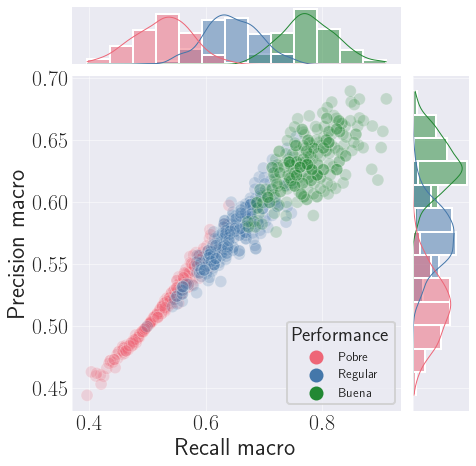

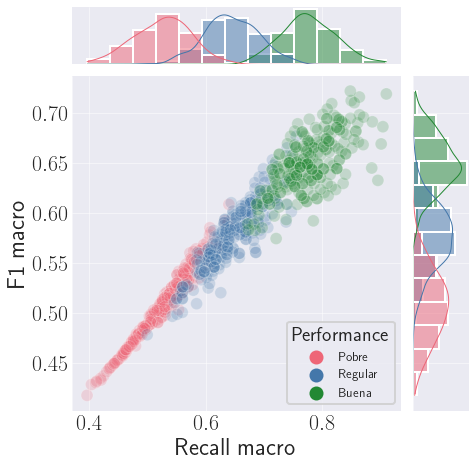

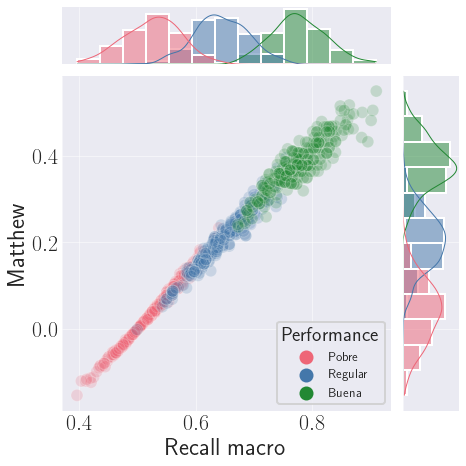

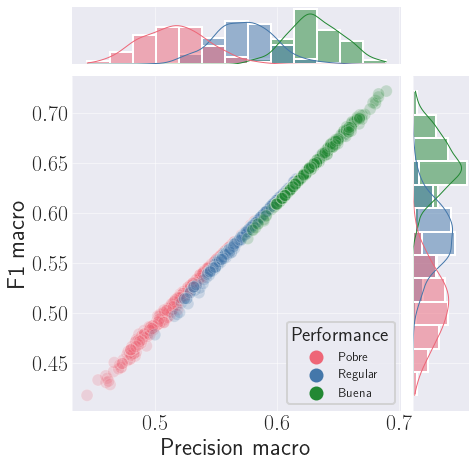

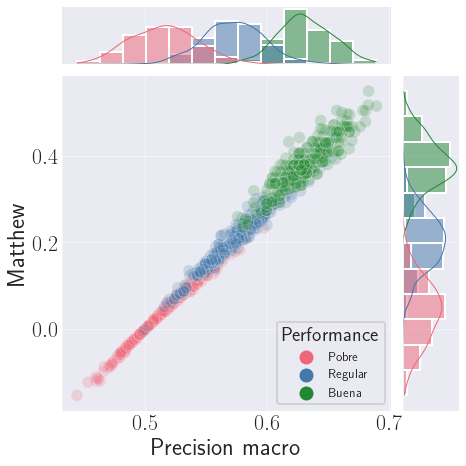

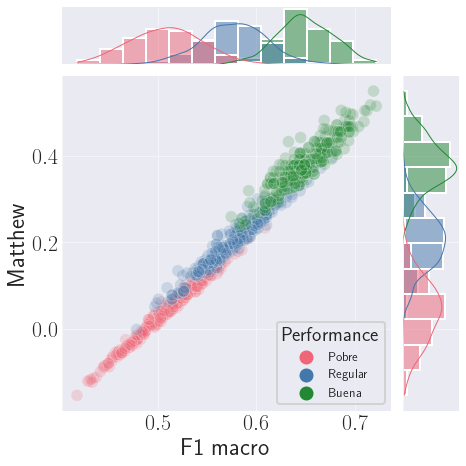

In [534]:
sns.set_context('poster', font_scale=1)
plot_compare_metrics("results_full_model", "final_scatter", plot_fun=plot_joint) #modelo-exp

In [55]:
#plot_each_file("porcentaje_exp_model", plot_compare_metrics_distribution,"dist_18_feb")

In [56]:
#plot_each_file("model_1", plot_compare_metrics_distribution,"dist_4_jul")

In [57]:
#plot_each_file("exp_1_agosto", plot_compare_metrics_distribution,"dist")

In [58]:
#plot_compare_metrics("porcentaje_exp_model", output_path="porcentaje_exp_model_9_exp", 
#                     filters={"error_exp": 9}) #modelo-exp


In [59]:
#plot_compare_metrics("model_1") #modelo

In [60]:
## Se ve que ambos incrementan en el mixto. Jugar con el alpha y re definir nombre de título

In [14]:

sns.set(font_scale = 1.3) 
sns.set_context('poster')
plot_figures_dir = '../../figures/metrics/'
def plot_distribution(df, plot_name='not_known.pdf', metric='matthew'):
    plot_title = plot_figures_dir + plot_name    
    with plt.style.context(['science', 'bright']):
        bright = plot_utils.tol_cset("bright")
        map_cols = map_names_for_plot()
        df = df.rename(columns=map_cols)
        g = sns.displot(data=df, 
                         x=map_cols[metric], kind='kde', hue=map_cols['percentil_tp'],
                         col=map_cols["imbalance"], fill=True,
                        palette=[bright.red, bright.blue, bright.green],
                        alpha=.5, linewidth=3, legend=True,  row=map_cols['n_size'])
         
            #ax.set_yticklabels(rotation=90)
        #ax.tick_params(labelbottom=True, which="both", left=False, bottom=False, top=False, right=False)
        for ax in g.axes.flatten():
            #ax.set_yticklabels(rotation=90)
            ax.tick_params(labelbottom=True, which="both", left=False, bottom=False, top=False, right=False)
        
            ax.set(ylabel='Distribución')
        #plt.legend(title="", loc='best', fontsize='medium', ncol=1,
        #                    framealpha=0, fancybox=False, edgecolor='black',)
        imbalance = r'$\delta$'
        for (row_key, col_key),ax in g.axes_dict.items():
            ax.set_title(f"m={row_key} - Desbalance = {col_key}")
    #plt.savefig("Customize_displot_facetgrid_plot_titles_Python.png")
        g._legend.set_title("Performance")
        #plt.legend(loc='upper left',bbox_to_anchor=(1,0.5))
        plt.savefig(plot_title, dpi=300)

In [36]:
folder_to_plot = "results_full_model"
saving_folder_plot = folder_to_plot + "_model_plotting"

In [16]:
df = collect_data_from(folder_to_plot) #exp

In [17]:
percentil_tp = {
    0.25: 'Pobre',
    0.5: 'Regular',
    0.75: 'Buena'
}
imbalance_category = {
    0.1: 'Alto',
    0.4: 'Bajo'
}

df = df.replace({'percentil_tp': percentil_tp})
df = df.replace({'imbalance': imbalance_category})

In [575]:
metrics = ['recall_weighted', "f1_weighted", "precision_weighted", 
           "matthew",
           'recall_micro', "precision_micro",
           'recall_macro', "precision_macro", "f1_macro"
          ]
#for metric in metrics:
#plot_distribution(df, metric=metric, plot_name=f'{metric}_distribucion_exp_1.pdf')

In [57]:
evaluation_dots_path = '../../results/ensamble/bagging_evaluation/evaluation_baggging_models.csv'
saving_folder_plot = '../../figures/ensemble/bagging/evaluation_ensemble'

In [60]:
plot_compare_metrics_with_evaluation(path_src=folder_to_plot, 
                                                  evaluation_dots_path=evaluation_dots_path, 
                                                  output_path=saving_folder_plot,
                                                  plot_fun=plot_joint_with_evaluation)

Index(['tn', 'fp', 'fn', 'tp', '$\delta$', 'Percentil', 'Precision micro',
       'Precision macro', 'Precision weighted', 'Recall micro', 'Recall macro',
       'Recall weighted', 'F1 macro', 'F1 weighted', 'Matthew', 'm',
       'error_exp', 'error_model'],
      dtype='object') Index(['Recall 0', 'Recall 1', 'F1 0', 'F1 1', 'Precision 0', 'Precision 1',
       'Recall macro', 'F1 macro', 'Precision macro', 'Matthew macro',
       'estimator'],
      dtype='object')
recall_macro {'recall_0': 'Recall 0', 'recall_1': 'Recall 1', 'f1_0': 'F1 0', 'f1_1': 'F1 1', 'precision_0': 'Precision 0', 'precision_1': 'Precision 1', 'recall': 'Recall', 'f1': 'F1', 'precision': 'Precision', 'matthew': 'Matthew', 'estimator': 'estimator', 'percentil_tp': 'Percentil', 'imbalance': '$\\delta$', 'exp': 'Experimental', 'model': 'Modelo', 'exp-model': 'Exp-modelo', 'n_size': 'm'}


KeyError: 'recall_macro'

In [40]:
folder_to_plot, evaluation_dots_path, saving_folder_plot, plot_joint_with_evaluation

('results_full_model',
 '../../results/ensamble/bagging_evaluation/evaluation_baggging_models.csv',
 'results_full_model_model_plotting',
 <function __main__.plot_joint_with_evaluation(df, plot_folder, plot_args={})>)

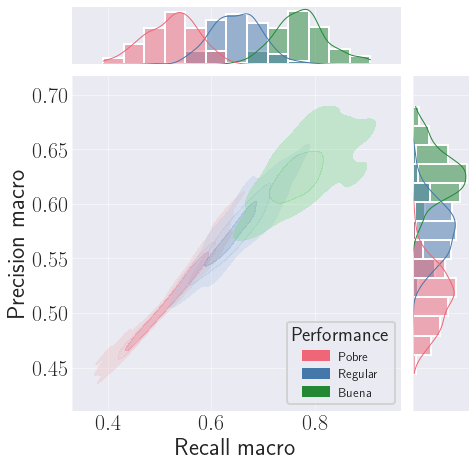

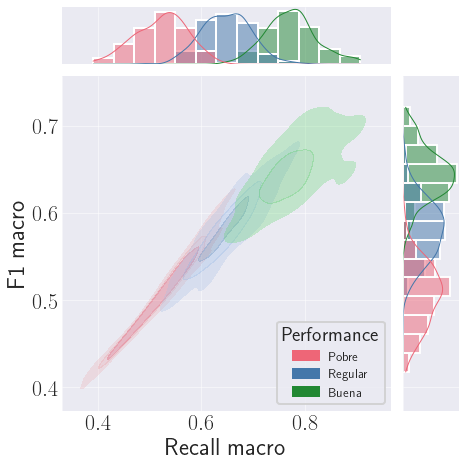

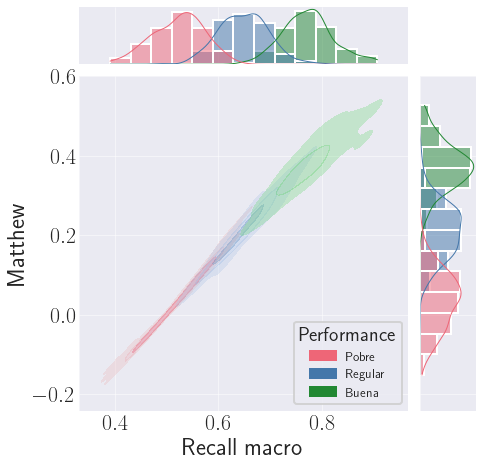

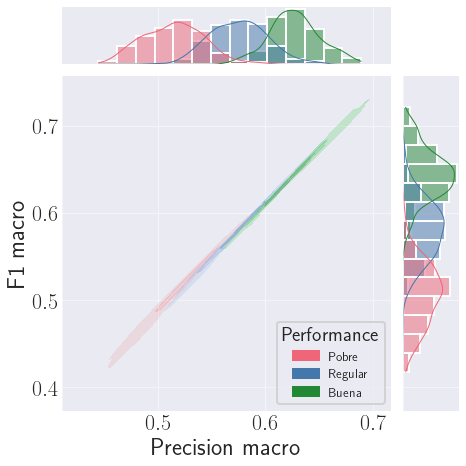

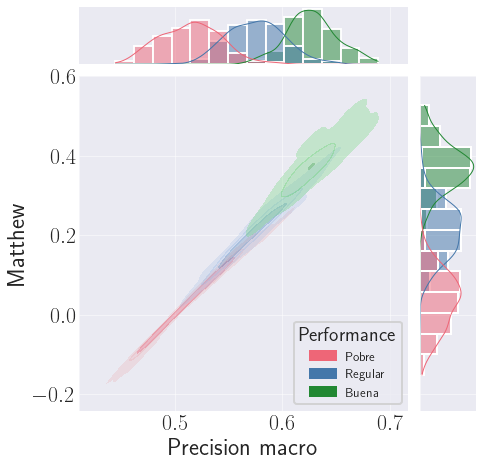

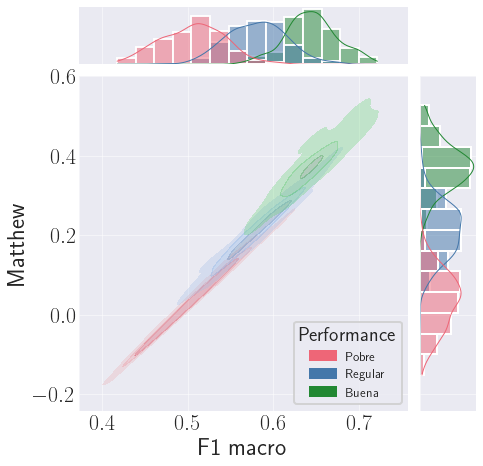

In [576]:
plot_compare_metrics(folder_to_plot, saving_folder_plot, plot_fun=plot_joint) #exp

In [185]:
#plot_merged_files_from("test", plot_scatter, plot_args={"x_metric": "precision_macro",
#                                                        "y_metric": "recall_macro"})

In [97]:
file_path_test = "{'positive': [0.1, 0.4], 'tn_percentil': [0.25, 0.5, 0.75], 'n_size': 75, 'm_matrices': 250, 'seed': 0, 'error_type': 'exp-model', 'error_prop': 0.15, 'error_exp': 4, 'error_model': 11}.csv"
folder = "porcentaje_exp_model"

In [82]:
path_src = folder / Path(file_path_test)


In [189]:
#plot_compare_metrics_distribution(path_src, "", plot_args={})

In [96]:
#plot_each_file("model_1", plot_joint, "con_boxplot", plot_args={"x_metric":"recall_macro"})

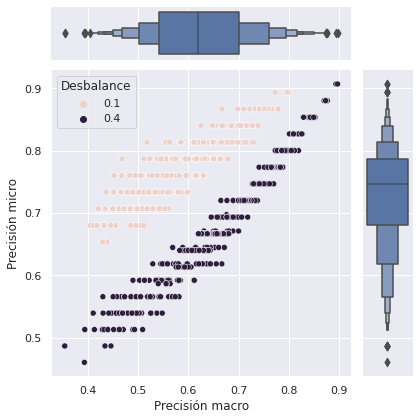

In [90]:
plot_joint(path_src, "porcentaje-exp-model-other", plot_args={"x_metric": "precision_macro",
                                                            "y_metric": "precision_micro"})

In [54]:
plot_files("exp_model_2", plot_compare_metrics_distribution, {})

In [78]:
plot_files("test", plot_compare_metrics_distribution, {}) 

### Imbalance affects distribution Overlapping

In [50]:
n_matrix_size = [500]
positive_proportions = [0.10, 0.2, 0.3, 0.4]
tp_percentiles = [0.25,0.5,0.75]
cm_samples = [250]

#distribution_plot(dataset, seed=seed, n_matrix_size=n_size, cm_sample=cm_sample)


In [99]:
from scipy.stats import norm
%matplotlib inline


In [33]:
def plot_joint(df, seed, x_metric, y_metric, hue_col, map_cols, imbalance, n, cm_sample):
    df = df[df.imbalance == imbalance]
    df.rename(columns=map_cols, inplace=True)
    g = sns.jointplot(data=df, x=map_cols[x_metric], y=map_cols[y_metric], hue=map_cols[hue_col], xlim = (-0.4,1.15), ylim = (0,1.1))
    g.plot_joint(sns.kdeplot, zorder=3, levels=1)
    g.plot_marginals(sns.rugplot, height=.05, clip_on=True)
  # g.savefig("img/recall_vs_{}_imbalance_{}.jpg".format(x_metric, imbalance), transparent=True,  facecolor='w')
    plt.savefig("img_final_cross/recall_vs_{}_imbalance_{}_seed_{}_n_{}_cm_{}.png".format(x_metric, imbalance, seed, n, cm_sample),facecolor='w', transparent=False, dpi=150)

def generate_plots(df, seed, n_matrix_size, cm_sample):
    posible_complement = ["precision_macro", "precision_micro", "f1_weighted", "f1_macro", "matthew"]

    for metric in posible_complement:
        for imbalance in positive_proportions:
            plot_joint(df, seed, metric, "recall_macro", "percentil_tp", map_names, imbalance, n_matrix_size, cm_sample)

## Cómo el desbalance puede afectar a las métricas

A menos desbalance, hay compuestos que teniendo datos donde cristaliza poco y otros para el cual cristaliza mucho..vamos a llegar
a que pueden tener las mismas métricas. El error modelado nos afecta mucho

In [202]:
from adjustText import adjust_text

def scatter_text(x, y, text_column, data, title="", xlabel="", ylabel=""):
    """Scatter plot with country codes on the x y coordinates
       Based on this answer: https://stackoverflow.com/a/54789170/2641825"""
    # Create the scatter plot
    p1 = sns.scatterplot(x, y, data=data, size = 8, legend=False)
    texts = []
    # Add text besides each point
    for line in data.index:
      #texts.append(p1.text(data[x][line]+0.01, data[y][line], data[text_column][line]))
      p1.text(data[x][line]+0.01, data[y][line], 
                 data[text_column][line], horizontalalignment='left', 
                 size='small', color='black')
   
    #adjust_text(texts, data[[text_column]])
    return p1

/home/belu/.local/share/virtualenvs/licentiate-thesis-repo-cz9ujhZI/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='precision_micro', ylabel='f1_macro'>

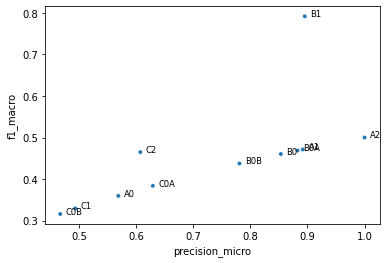

In [203]:
scatter_text("precision_micro", "f1_macro", "level", dataset_mean, "title", "recall", "positive rate")


/home/belu/.local/share/virtualenvs/licentiate-thesis-repo-cz9ujhZI/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='recall_macro', ylabel='recall_micro'>

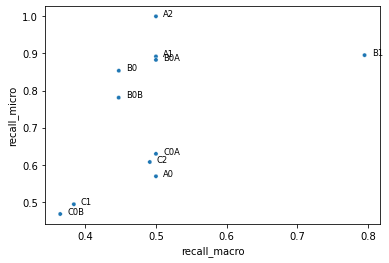

In [204]:
scatter_text("recall_macro", "recall_micro", "level", dataset_mean, "title", "recall", "positive rate")


/home/belu/.local/share/virtualenvs/licentiate-thesis-repo-cz9ujhZI/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='precision_macro', ylabel='f1_macro'>

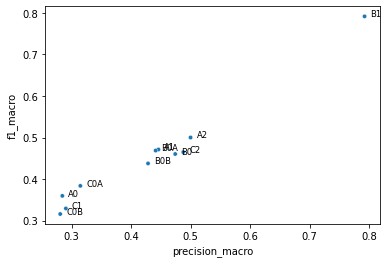

In [205]:
scatter_text("precision_macro", "f1_macro", "level", dataset_mean, "title", "recall", "positive rate")


/home/belu/.local/share/virtualenvs/licentiate-thesis-repo-cz9ujhZI/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='precision_macro', ylabel='recall_macro'>

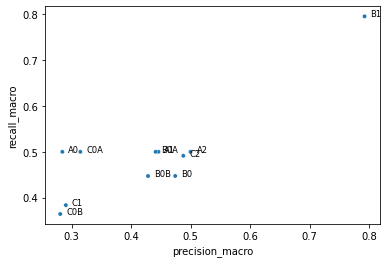

In [206]:
scatter_text("precision_macro", "recall_macro", "level", dataset_mean, "title", "recall", "positive rate")


/home/belu/.local/share/virtualenvs/licentiate-thesis-repo-cz9ujhZI/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='precision_micro', ylabel='recall_micro'>

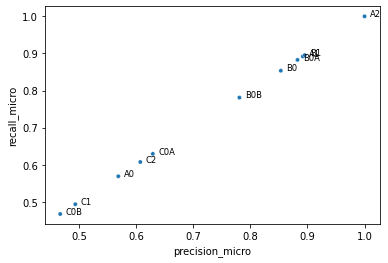

In [207]:
scatter_text("precision_micro", "recall_micro", "level", dataset_mean, "title", "recall", "positive rate")


In [208]:
metrics_names = []
metric = []
beta = []
average = []

experiments = pd.DataFrame.from_dict({"name": metrics_names,
                                     "metric": metric,
                                     "beta" : beta,
                                     "average": average
                                    })

In [22]:
metrics_names = ["accuracy", "f1", "precision", "hit rate", "recall"]
metrics_funs = [accuracy, F1, precision, hit_rate, recall]
for (label, metric) in zip(metrics_names, metrics_funs):
    dataset[label] = dataset.apply(lambda row : metric(row), axis=1)

In [23]:
dataset.groupby(by="level").mean()

,accuracy,f1,precision,hit rate,recall
level,,,,,
A,0.650294,0.000000,1.000000,0.000000,0.000000
B,0.879675,0.000000,1.000000,0.000000,0.000000
C,0.800472,0.000000,1.000000,0.000000,0.000000
D,0.882558,0.000000,1.000000,0.000000,0.000000
E,0.907867,0.334926,0.675900,0.324100,0.675900
F,0.700213,0.250248,0.429452,0.570548,0.429452
